# Estimating Eigenfunctions of the Infintesimal generator


This example is a reproduction of the second experiment of _"Learning the Infinitesimal Generator of Stochastic Diffusion Processes"_>. We use `kooplearn` to approximate the leading eigenfunctions of the infinitesimal generator of the overdamped Langevin dynamics
$$
X_{t + 1} = X_t -\frac{1}{\gamma}\nabla V(X_t)\Delta t + \frac{\sigma}{\gamma}\sqrt(\Delta t)\xi_t
$$
Here, $V$ is the potential function, $\gamma$ is a damping coefficient, and $\sigma$ is proportional to the temperature of the process: the higher the $\sigma$, the noisier is the dynamics. In this example we will study the so-called _Prinz Potential_<cite data-footcite="Prinz2011">(Prinz et al. 2011)</cite>:

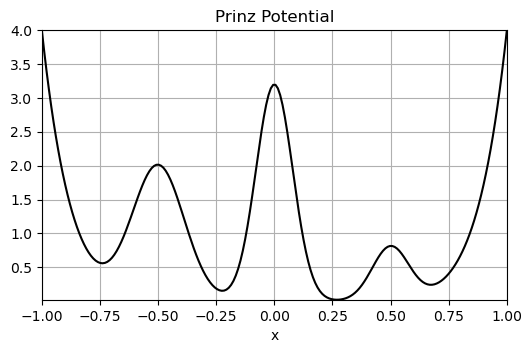

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [6., 3.5]

def prinz_potential(x):
    return 4 * (
        x**8
        + 0.8 * np.exp(-80 * (x**2))
        + 0.2 * np.exp(-80 * ((x - 0.5) ** 2))
        + 0.5 * np.exp(-40 * ((x + 0.5) ** 2))
    )

x = np.linspace(-1, 1, 200)
plt.plot(x, prinz_potential(x), 'k')
plt.margins(0)
plt.xlabel('x')
plt.title("Prinz Potential")
plt.grid()


`kooplearn` exposes the function [make_prinz_potential](../generated/kooplearn.datasets.make_prinz_potential.rst) to simulate the overdamped Langevin dynamics with this potential. 

In [2]:
from kooplearn.datasets import make_prinz_potential

gamma = 1.0
sigma = 2
data = make_prinz_potential(X0 = 0, n_steps=int(5e6), gamma=gamma, sigma=sigma)

for overdamped Langevin processes, the inverse temperature satisfies the relation $\beta = 2\gamma/\sigma^2$. With this, we can easily verify that `data` approximately samples the Boltzmann distribution $e^{-\beta V(x)}$.

Text(0.5, 0, 'x')

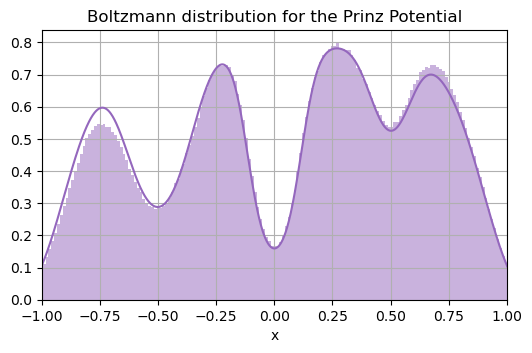

In [3]:
from scipy.integrate import romb


def compute_boltzmann_density(x, gamma, sigma):
    beta = 2*gamma/(sigma**2)
    pdf = np.exp(-beta*prinz_potential(x))
    total_mass = romb(pdf, dx=x[1] - x[0])
    return pdf/total_mass

x = np.linspace(-2, 2, 2048 + 1)
density = compute_boltzmann_density(x, gamma ,sigma)
plt.hist(data, bins=200, density=True, alpha=0.5, color="tab:purple")
plt.plot(x, density, color='tab:purple')
plt.xlim(-1, 1)
plt.grid()
plt.title("Boltzmann distribution for the Prinz Potential")
plt.xlabel("x")

In [4]:
data.values[0]

array([0.])

In [5]:
test = data.values
mean = 0.0
for i in range(len(test[::10])-1):
    mean += (test[::10][i]-test[::10][i+1])*(test[::10][i]-test[::10][i+1])
friction = (mean/((len(test[::10])-1)))/(2*10*1e-4)

In [6]:
friction

array([1.96130636])

`kooplearn` exposes the function [make_prinz_potential](../generated/kooplearn.datasets.make_prinz_potential.rst) to simulate the overdamped Langevin dynamics with this potential. 

We then define the parameters of the model : shift, and friction ($\sigma / \gamma$)

In [7]:
eta = 5
gamma_rbf =1/(2*(0.1)**2)
subsample=1000
train_data = data.iloc[::subsample]
n = train_data.shape[0]
friction = np.array([2.0])

We fit the model with the data, and a rank of 5

In [8]:
from kooplearn.kernel._generator import GeneratorDirichlet
kernel_grad = GeneratorDirichlet(n_components=5,gamma=gamma_rbf, alpha=1e-5,friction=friction,shift=eta)
kernel_grad.fit(train_data)

,n_components,5
,reduced_rank,True
,kernel,'rbf'
,gamma,49.99999999999999
,degree,3
,coef0,1
,kernel_params,None
,alpha,1e-05
,n_jobs,1
,friction,array([2.])
,shift,5


We then compute and plot the eigenfunctions

In [9]:

from kooplearn.datasets import compute_prinz_potential_eig
def normalize_eigenfunctions(functions, x, density):
    abs2_eigfun = (np.abs(functions) ** 2).T  # f(x)**2
    abs2_eigfun *= density  # Compute the norm with respect to the Boltzmann measure.
    dx = x[1] - x[0]
    funcs_norm = np.sqrt(romb(abs2_eigfun, dx=dx, axis=1))  # Norms
    functions *= funcs_norm**-1.0  # Normalize
    return functions
def standardize_sign(eigenfunction, reference):
    norm_p = np.linalg.norm(eigenfunction + reference)
    norm_m = np.linalg.norm(eigenfunction - reference)
    if norm_p <= norm_m:
        return -1.0*eigenfunction
    else:
        return eigenfunction



evals, ef_right = kernel_grad.eig(eval_right_on=x[:,np.newaxis])
ef_right = normalize_eigenfunctions(ef_right, x, density)

dt = data.attrs["params"]["dt"]
_, reference_eigfuns = compute_prinz_potential_eig(
    gamma, sigma, dt, eval_right_on=x, num_components=5
)
reference_eigfuns = normalize_eigenfunctions(reference_eigfuns, x, density)



/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but GeneratorDirichlet was fitted with feature names
  warnings.warn(


/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/tdevergne@iit.local/anaconda3/envs/kooplearn-dev/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


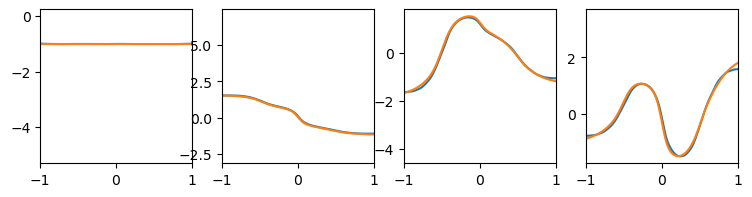

In [10]:
fig, axs = plt.subplots(ncols=4, figsize=(9, 2))
for i in range(4):
    ef_right[:, i] = standardize_sign(
                    ef_right[ :, i], reference_eigfuns[:, i]
                )
    axs[i].plot(x, ef_right[:,i])
    axs[i].plot(x,reference_eigfuns[:,i])
    axs[i].set_xlim(-1,1)

The generator can then be used to forecast the evolution of observables given an initial condition. Here, we compute the evolution of the probability density by predicting the expectation value of being in one bin at time $t$ given an initial condition

In [16]:
#from linear_operator_learning.kernel.structs import *
#from linear_operator_learning.kernel.dynamics.structs import *
x = np.linspace(-1.2,1.2,130)
pred = []
for i in range(len(x)-1):
    interval = np.where(np.logical_and(train_data > x[i], train_data < x[i+1]), 1 ,0)
    predictions = kernel_grad.predict(train_data,t=1.0,observable=interval,recompute=False) 
    pred.append(predictions)

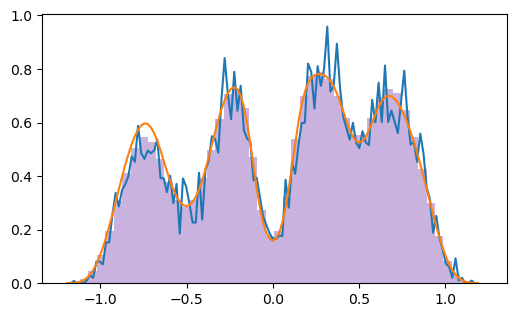

In [17]:
import matplotlib.pyplot as plt
xcenters = (x[:-1] + x[1:]) / 2
plt.hist(data, bins=50, density=True, alpha=0.5, color="tab:purple")
density = compute_boltzmann_density(xcenters, gamma ,sigma)
plt.plot(xcenters,np.array(pred)[:,100]/(x[1]-x[0]))
plt.plot(xcenters, density)